#### Marsh Erosion

This is one approach to book-keeping for modeling marsh edges that are not well resolved by the grid. It has the following properties.
* Conserves mass while eroding the marsh edge and supplying sediment to the adjacent tidal flat
* Models erosion as a marsh-edge scarp retreat rate
* Maintains elevation on top of marsh, and
* Has a mechanism for converting eroded marsh cells to wet tidal flat cells
* Tracks fraction of marsh cell that has eroded
* Tracks face elevation of marsh-edge scarp

The main feature is a variable xm that tracks the distance of marsh retreat. This can be combined with the cell size dx to calculate xm/dx, the horizontal fraction of the cell that has marsh. While any marsh remains (xm/dx > 0), the elevation of the marsh cannot decrease, but the mass of sediment in the cell decreases with marsh erosion. This is monitored by xm/dx 

This example is 1DH, with erosion in one direction, but it can be implemented in 2DH.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize

# cell size
dx = 10.
dy = 10.

rhos = 2650.
cb = .5

# thickness of cells
dz = np.array([2.,2.,2.,2.,2.,3.,3.,3.,3.,3.])

# cumulative erosion so far (none)
xm = np.zeros_like(dz)

nx = len(dz)

# marsh mask
mmask = np.array([0.,0.,0.,0.,0.,1.,1.,1.,1.,1.])

# location of left side of cells
xl = dx*np.arange(nx)
# location of center of cells
xc = np.cumsum(np.arange(nx)*dx)

# initial scarp elevations (these are located on left edge, so need to add one for first cell)
zm = mmask*np.append(np.array([0.]),np.diff(dz))

tt = 50*24.*3600.       # 50 days
dt = 24.*3600.          # dt = 1 day
nt = int(np.ceil(tt/dt))

# cell volumes
V = dx*dy*dz

# sediment mass in each cell
M = rhos*(1-cb)*V

# total sediment mass in system
sumM = np.sum(M)

# horiz marsh cell fraction
fmh = (1. - (xm/dx)*mmask)
# vertical marsh cell fraction
fmv = (1. - (zm/dz)*mmask)
# total marsh cell fraction
fm = (1.-(xm/dx+zm/dz)*mmask)

# declare arrays for storing output
dz_a = np.nan*np.ones((nt,nx))
M_a =  np.nan*np.ones((nt,nx))


# Run
for i in range(nt):
    
    # calculate erosion distance (constant at 300 m/yr = 0.82 m/day)
    dxm = dt*300./(3600.*24.*365.)*(np.abs(zm)>0.)
    
    # ensure that cumulative scarp erosion does not exceed dx
    for j in range(nx):
        if (dxm[j]+xm[j])>dx :
            dxm[j]=dx-xm[j]       
    
    # increment cumulative scarp erosion distance
    xm += dxm
    
    # calc eroded mass from volume of scarp erosion
    dM = rhos*(1-cb)*dxm*dy*zm
    
    # subtract mass from eroding marsh cell
    M -= dM
    
    # add mass to cell to left (or water column)
    M[0:-1] += dM[1:]
    
    # update volumes
    V = M/(rhos*(1-cb))

    # if there is deposition, the additional cell height should be 
    # based on the (remaining) horizonal area of marsh
    # update dz
        
    # update horiz marsh cell fraction
    fmh = (1. - (xm/dx)*mmask)
    
    # Criteria to use for marsh mask:
    # If there is any horizontal fraction left, and it was marsh, it is still marsh.
    # (one-way...does not generate new marsh)
    mmask = np.ceil(fmh)*mmask

    # collapse the elevation of new non-marsh cells
    for j in range(nx):
        if (mmask[j]<=0.5) :
            dz[j]=V[j]/(dx*dy)

        
    # recalculate scarp heights
    zm = mmask*np.append(np.array([0.]),np.diff(dz))
                   
    # update vertical marsh cell fraction
    fmv = (1. - (zm/dz)*mmask)
    
    # update total marsh cell fraction
    fm = (1.-(xm/dx+zm/dz)*mmask)
   
    # store results for each time step
    dz_a[i,:]=dz
    M_a[i,:]=M


array([ 3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.,  3312500.,  3312500.,  3312500.,  3312500.,
        3312500.,  3312500.])

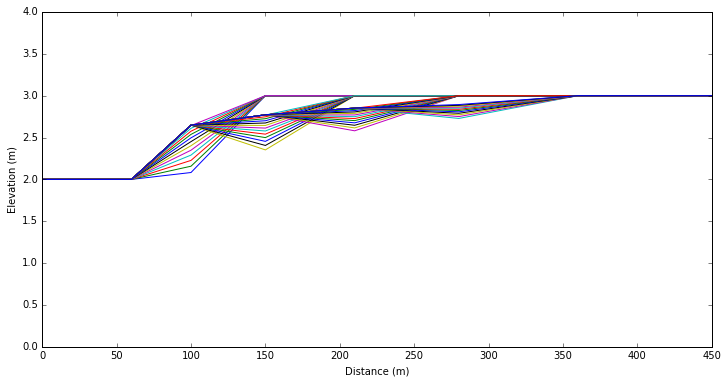

In [3]:
plt.figure(figsize=(12,6))
for i in range(nt):
    plt.plot(xc,dz_a[i][:])
    plt.ylim((0.,4))
    plt.ylabel('Elevation (m)')
    plt.xlabel('Distance (m)')
    
np.sum(M_a,1)